## Diagnosis of diabetes.

- Using data from `sklearn` (`datasets.load_diabetes()`) - reading from a file;

- Splitting data into training and validation data in the proportion of 70% / 30%;

- Testing different types of networks with one and two hidden layers.



#### Imports

In [4]:
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation
from keras.activations import sigmoid, tanh, relu, linear
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from keras.initializers import HeNormal, HeUniform, GlorotNormal, GlorotUniform
from tensorflow.keras.initializers import random_uniform
from keras.losses import BinaryCrossentropy, binary_crossentropy, mse
from keras.models import clone_model
from sklearn import datasets

import matplotlib.pyplot as plt
import pandas as pd

#### Plot structure

In [5]:
import matplotlib.pyplot as plt

def plot_print(learn_loss, test_loss, test_accur, epoches):
    fig = plt.figure()
    plt.plot(epoches, learn_loss, label='train_loss')
    plt.plot(epoches, test_loss, label='test_loss')
    plt.plot(epoches, test_accur, label='test_accur')
    plt.legend()
    plt.show()
    plt.close(1)

#### Classes of network models

In [6]:
class ModelShape:
    def __init__(self, input_shape: int, output_shape: int, hidden_layer_size, activation_input, activation_output,
                 initialization: str, learning_rate, loss, optimizer, use_bias: bool = True):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.hidden_layer_size = hidden_layer_size
        self.activation_input = activation_input
        self.activation_output = activation_output
        self.initialization = initialization
        self.learning_rate = learning_rate
        self.loss = loss
        self.optimizer = optimizer
        self.use_bias = use_bias

    @staticmethod
    def build_model(model, input_shape):
        model.build((None, input_shape))

    @staticmethod
    def compile_model(model, optimizer, learning_rate, loss):
        optimizer = optimizer(learning_rate=learning_rate)
        model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

    @staticmethod
    def get_build_and_compiled_model(model, input_shape, optimizer, learning_rate, loss):
        ModelShape.build_model(model, input_shape)
        ModelShape.compile_model(model, optimizer, learning_rate, loss)


class BaseModel(ModelShape):
    def __init__(self, input_shape: int, output_shape: int, hidden_layer_size, activation_input, activation_output,
                 initialization: str, learning_rate, loss, optimizer, use_bias: bool = True):
        super().__init__(input_shape, output_shape, hidden_layer_size, activation_input, activation_output,
                         initialization, learning_rate, loss, optimizer, use_bias)
        self.model = None

    def create_model(self):
        self.model = Sequential()
        for hidden_layers_size in self.hidden_layer_size:
            self.model.add(Dense(hidden_layers_size, use_bias=self.use_bias,
                                 activation=self.activation_input,
                                 kernel_initializer=self.initialization,
                                 bias_initializer=self.initialization))
        self.model.add(Dense(self.output_shape, use_bias=self.use_bias, activation=self.activation_output,
                             kernel_initializer=self.initialization,
                             bias_initializer=self.initialization))

    def show_summary(self):
        return self.model.summary()


class ActivationInputAndInitModel:
    def __init__(self, activation, initialization):
        self.initialization = initialization
        self.activation = activation

#### Network training and testing - saving results

In [7]:
def model_training_epoches(all_models, model_names, test_number, max_epochs, epochs_step, batch_size, data_learn_x,
                           data_learn_y, data_test_x, data_test_y, file_name="data_models_training.txt"):

    models_scores = {}
    for model, model_name in zip(all_models, model_names):
        # val_loss_model = []
        learn_loss_all = []
        test_loss_all = []
        test_accur_all = []
        epochs_all = [epoc for epoc in range(0, max_epochs + 1, epochs_step)]
        min_test_loss = []
        max_result_all = []
        min_test_epoches = []
        stop_training_epoches = {}
        stop_training_epoches_mean = max_epochs

        for test_nr in range(test_number):
            model_test = clone_model(model.model)
            ModelShape.get_build_and_compiled_model(model_test, model.input_shape, model.optimizer,
                                                    model.learning_rate, model.loss)
            test_loss_first = 1
            # learn_loss_first = 1
            test_loss_dec = 0
            # bigger_los_difference = 0
            learn_loss = []
            test_loss = []
            test_result = []
            for epoch in range(0, max_epochs + 1, epochs_step):
                # Training
                model_test.fit(data_learn_x, data_learn_y, epochs=epochs_step, verbose=0, batch_size=batch_size)

                # Tests and save results
                learn_loss.append(model_test.evaluate(data_learn_x, data_learn_y, verbose=0))
                tst_lss, tst_result = model_test.evaluate(data_test_x, data_test_y, verbose=0)
                test_loss.append(tst_lss)
                test_result.append(tst_result)
                # learn_loss_second = learn_loss

                # Stop learning if loss on the test data starts to rise.
                # Currently, I only save the epoch when we "should" stop learning.
                test_loss_second = test_loss[-1]
                if test_loss_first < test_loss_second:
                    test_loss_dec += 1
                # if (test_loss_first - learn_loss_first) / test_loss_first < (test_loss_second - learn_loss_second) / test_loss_second
                if epoch > 50 and test_loss_dec == 3:
                    stop_training_epoches[test_nr] = epoch
                    # break
                test_loss_first = test_loss_second

            # Plots data
            learn_loss_all.append(learn_loss)
            test_loss_all.append(test_loss)
            test_accur_all.append(test_result)
            min_test_loss.append(np.min(np.array(test_loss)))
            max_result_all.append(np.max(np.array(test_result)))
            min_test_epoches.append(epochs_all[test_loss.index(min_test_loss[-1])])
            # val_loss_model.append(test_loss[-1])

        # Save results
        models_scores[model_name] = [np.mean(min_test_loss), np.mean(max_result_all),
                                     np.mean(np.array(min_test_epoches))]
        stop_training_epoches_mean = np.mean(np.array(list(stop_training_epoches.values())))

        # Calculate plots data
        learn_loss_to_plot = np.mean(np.array(learn_loss_all), axis=0)
        test_loss_to_plot = np.mean(np.array(test_loss_all), axis=0)
        test_accur_to_plot = np.mean(np.array(test_accur_all), axis=0)
        print("MODEL:")
        print(model_name)
        print("Average model results: \n")
        plot_print(learn_loss_to_plot[:, 0].tolist(), test_loss_to_plot.tolist(),
                   test_accur_to_plot.tolist(), epochs_all[:len(test_loss_to_plot)])
        print(f'On average, early stopping occured at epoch: {stop_training_epoches_mean}')
        print("Results [best_test_loss, best_test_accurate, best_epoch]:")
        print(f'{models_scores[model_name]}\n')

        print("\nThe last training and results of the model: \n")
        plot_print((np.array(learn_loss)[:, 0]).tolist(), test_loss,
                   test_result, epochs_all[:len(test_loss_to_plot)])
        print("Results [best_test_loss, best_test_accurate, best_epoch]:")
        print(f'[{min_test_loss[-1]}, {max_result_all[-1]}, {min_test_epoches[-1]}]')
        if test_number - 1 in stop_training_epoches:
            print(f'Early stopping occured at epoch: {stop_training_epoches[test_number - 1]}\n')
        print('\n\n')

    return models_scores

#### Prepare data for training and testing

In [8]:
data = pd.read_csv('pima-indians-diabetes.data.csv')
data_learn_count = int(0.7 * len(data))
data_learn = np.asarray(data[:data_learn_count])
data_learn_x = data_learn[:, :-1]
data_learn_y = data_learn[:, -1:]

data_test = np.asarray(data[data_learn_count:])
data_test_x = data_test[:, :-1]
data_test_y = data_test[:, -1:]

#### Creating network models with specific parameters that had the best results during testing - two networks are presented (one single-layer and one two-layer)

In [9]:
learning_rates = [0.001]

hidden_layer_sizes = [[100]]
hidden_layers_sizes = [[100, 50]]

model_names = []
small_models = []
big_models = []

for learning_rate in learning_rates:
    for hidden_layer_size in hidden_layer_sizes:
        small_models.append(BaseModel(data_learn_x.shape[1], data_learn_y.shape[1], hidden_layer_size,
                                      'relu', 'sigmoid', 'uniform', learning_rate,
                                      binary_crossentropy, Adam))
        model_names.append(f'hidden_layer_size: {hidden_layer_size}\n'
                           f'activation_input: relu, activation_output: sigmoid,\n'
                           f'initialization: uniform\n'
                           f'learning_rate: {learning_rate}, loss_function: binary_crossentropy,\n'
                           f'optimizer: Adam\n')
        
    for hidden_layer_size in hidden_layers_sizes:
        big_models.append(BaseModel(data_learn_x.shape[1], data_learn_y.shape[1], hidden_layer_size,
                                    'relu', 'sigmoid', 'uniform', learning_rate,
                                    binary_crossentropy, Adam))
        model_names.append(f'hidden_layer_size: {hidden_layer_size}\n'
                           f'activation_input: relu, activation_output: sigmoid,\n'
                           f'initialization: uniform\n'
                           f'learning_rate: {learning_rate}, loss_function: binary_crossentropy,\n'
                           f'optimizer: Adam\n')

all_models = small_models + big_models

### Main program - parameter initialization with best results

MODEL:
hidden_layer_size: [100]
activation_input: relu, activation_output: sigmoid,
initialization: uniform
learning_rate: 0.001, loss_function: binary_crossentropy,
optimizer: Adam

Average model results: 



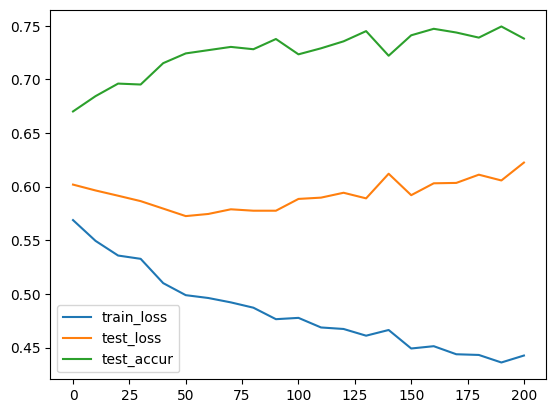

On average, early stopping occured at epoch: 84.44444444444444
Results [best_test_loss, best_test_accurate, best_epoch]:
[0.5592047274112701, 0.7649350583553314, 78.0]


The last training and results of the model: 



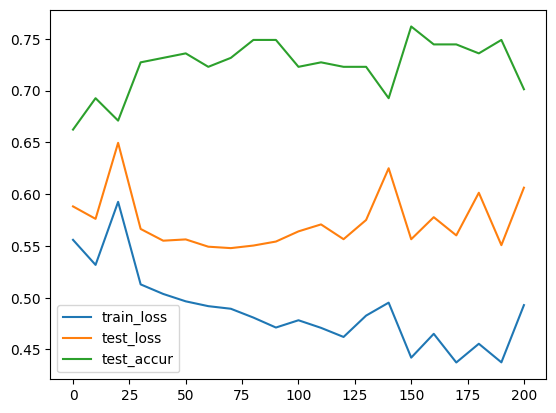

Results [best_test_loss, best_test_accurate, best_epoch]:
[0.5478848218917847, 0.761904776096344, 70]
Early stopping occured at epoch: 80






In [ ]:
for model in all_models:
    model.create_model()

test_number = 10
max_epochs = 200
# Selection of parameters with the best results in the models.
epochs_step = 10
batch_size = 5
# file_name = f'data_models_training_epoches_100.txt'

models_scores = model_training_epoches(all_models, model_names, test_number, max_epochs, epochs_step, batch_size,
                                       data_learn_x, data_learn_y, data_test_x, data_test_y)

# models_scores = {k: v for k, v in sorted(models_scores.items(), key=lambda item: item[1][0])}
# for key, value in models_scores.items():
#     print(key)
#     print(f'{value}')
#     print('\n\n')         

### The highest accuracy value obtained: approx. 78%

#### The best found configuration of parameters for the above task for both types of networks (single and double hidden layers):<br>
The size of the first hidden layer: approx. 100 (100 and 50 for two-layer network);<br>
Input activation function: relu;<br>
Output activation function: sigmoid;<br>
Weight initialization: uniform;<br>
Learning rate: 0.001; <br>
Loss: binary_crossentropy; <br>
Optimizer: Adam.<br>

batch_size: 5

#### Size of layers:<br>
When increasing the number of neurons in layers in networks with two hidden layers (from 100 upwards at the first layer - the next one is twice as small), the results did not improve (only the best results appeared several epochs earlier). In networks with one hidden layer, the more neurons in the layer (from 100 upwards), the worse the results.<br><br>

#### Activation functions:<br>
ReLU helps when dealing with the disappearing gradient problem (fading of the error at lower layers, which greatly degrades the learning speed). It is much more effective with more hidden layers. Nevertheless, using tanh as an activation function of the input (hidden) layers does not differ significantly from the results of relu (with one and two layers).<bt>

Sigmoid as an output layer activation function fits the problem of the above task (binary classification) - thanks to the output interval 0 - 1.<br><br>

#### Weight initialization:<br>
Here there was a lot of testing. Apparently, HeNormal agrees well with the ReLU activation function - in this case, however, uniform won out.<br><br>

#### Learning rate:<br>
0.001 seemed an appropriate value (at 0.01 the graphs jumped, at 0.0001 learning was slow without significant improvement). Intermediate values between 0.001 and 0.0001 can still be tested.<br><br>

#### Loss function:<br>
Binary_crossentropy is suitable for tasks with binary classification.<br><br>

#### Optimizer:<br>
There were several tests. Adam was one of the better ones.<br><br>

#### Comparison of network types:
I expected that a network with two hidden layers would do better than a network with one layer. The results are comparable (for a two-layer network: 100, 50 and a single-layer network: 100), although the single-layer network is a little better (in loss value and prediction accuracy). This shows that networks with fewer layers can be better than networks with more layers (plus faster in learning) in certain problem cases.<br><br>

#### Early stopping:
We should stop learning when the loss value for test data begins to increase (instead of decreasing) - at the appearance of network overfitting. It is difficult to say unequivocally when this occurs - the loss function for the test data may increase several times before falling again (we may stop learning too early).<br>
You can:<br>
- check how many times the function decreases (compare the previous and current loss) - stop learning at some point,<br>
- check whether the current loss is greater than the previous one (e.g. a certain number of epochs earlier), if so - stop learning if the actual_loss/previous_loss ratio is sufficiently large,<br>
- arrange combinations of different methods.<br>

The first of these methods was used.